<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 7 - Atenção 
**Nome:** Wesley Seidel Carvalho

**Numero Usp:** 6544342













______________

Nessa lista vamos implementar nosso próprio modelo de atenção para uma tarefa de tradução. Ao invés de traduzirmos entre linguagens naturais, nós vamos realizar uma tarefa de tradução muito mais simples: tradução de formatos de data. A tarefa é receber uma data em um formato qualquer e transforma-la em um formato padrão YYYY-MM-DD.

Optamos por essa abordagem para evitar termos que passar horas treinando um modelo em GPU, a ideia foi inspirada em um exercicio do curso _Sequence Models_ da DeepLearning.AI no Coursera.



Para essa lista também será util se familiarizar com a [API funcional do Keras](https://keras.io/guides/functional_api/) para construir modelos, algumas arquiteturas não são possiveis de serem expressadas como [modelos sequenciais]().


In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow import keras
import numpy as np

from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

# Dados

Utilizando a biblioteca Faker e Babel nós iremos gerar um dataset de datas aleatórias em formatos distintos, nosso objetivo é gerar um modelo capaz de traduzir estes formatos arbitrarios para nosso formato pré-estabelecido.

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)
Tx = np.max([len(dataset[i][0]) for i in range(len(dataset))])
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)
print("Tx:", Tx)
print("Ty:", Ty)
print("human_vocab size:", len(human_vocab) )
print("machine_vocab size:", len(machine_vocab) )

100%|██████████| 10000/10000 [00:00<00:00, 11991.35it/s]


X.shape: (10000, 37)
Y.shape: (10000, 10)
Xoh.shape: (10000, 37, 39)
Yoh.shape: (10000, 10, 11)
Tx: 37
Ty: 10
human_vocab size: 39
machine_vocab size: 11


In [3]:
index = 0
print("Data original:", dataset[index][0])
print("Data target:", dataset[index][1])
print()
print("Original após pré-processamento (indices):", X[index])
print("Target após pré-processamento (indices):", Y[index])
print()
print("Tamanho do vetor de entrada (deve ser igual ao Tx):", len(X[index]))
print("Tamanho do vetor de saida   (deve ser igual ao Ty):", len(Y[index]))
print()
print("Original após pré-processamento  (one-hot):", Xoh[index])
print("Target após pré-processamento  (one-hot):", Yoh[index])

Data original: 9 mai. 1998
Data target: 1998-05-09

Original após pré-processamento (indices): [13  0 24 14 21  2  0  5 13 13 12 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38]
Target após pré-processamento (indices): [ 2 10 10  9  0  1  6  0  1 10]

Tamanho do vetor de entrada (deve ser igual ao Tx): 37
Tamanho do vetor de saida   (deve ser igual ao Ty): 10

Original após pré-processamento  (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target após pré-processamento  (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Atenção

Como comentamos em sala de aula, diversas funções de atenção existem, para nosso modelo vamos definir uma função simples que utiliza 2 camadas densas como função score.


## <font color='blue'>Questão 1 </font>


Defina a função `one_step_attention` que deve receber os stack de hidden states h da Bi-LSTM, que é um numpy-array de shape (m, Tx, 2*n\_a) e s\_prev, o ultimo hidden state da camada LSTM pós atenção, que é um numpy-array de shape (m, n\_s)

Utilize a camada [RepeatVector](https://keras.io/api/layers/reshaping_layers/repeat_vector/) para que h e s\_prev possuam as mesmas dimensões, em seguida [concatene](https://keras.io/api/layers/merging_layers/concatenate/) os arrays e use 2 camadas densas seguidas de uma ativação softmax. Por ultimo, realize uma combinação dos pesos de atenção obtidos dessa ultima camada de ativação com os hidden states h originais para gerar um vetor de contexto, a camada [Dot](https://keras.io/api/layers/merging_layers/dot/) será útil.

In [4]:
#Seu código aqui

# Resumo das informações:
# h:      shape (m, Tx, 2*n_a) --- é stack de hidden states h da Bi-LSTM
# s_prev: shape (m, n_s)       --- o ultimo hidden state da camada LSTM pós atenção, que é um numpy-array
#
# Tx.: 37 --- Tamanho do vetor de entrada
# Ty.: 10 --- Tamanho do vetor de saida
# m..: (acho que é o batch size)
# n_s: 64 --- Peguei no codigo da proxima celula
# n_a: 32 --- Peguei no codigo da proxima celula
#
# a) Utilize a camada RepeatVector para que h e s_prev possuam as mesmas dimensões, 
# b) em seguida concatene os arrays e use 2 camadas densas seguidas de uma ativação softmax.
# c) Por ultimo, realize uma combinação dos pesos de atenção obtidos dessa ultima camada de 
# ativação com os hidden states h originais para gerar um vetor de contexto, a camada Dot será útil
layer_repeat_vector = RepeatVector(Tx)
# layer_concatenator = Concatenate()
layer_concatenator = Concatenate(axis=-1)
# layer_dense1 = Dense(32)
# layer_dense2 = Dense(32)
layer_dense1 = Dense(32, activation='tanh')
layer_dense2 = Dense(16, activation='relu')
# layer_activator = Dense(32, activation='softmax')
layer_activator = Activation('softmax', name='attention_weights')
# layer_dot = keras.layers.Dot(axes=(1, 1))
layer_dot = keras.layers.Dot(axes=1)




# repeator = RepeatVector(Tx)
# concatenator = Concatenate(axis=-1)
# densor1 = Dense(10, activation = "tanh")
# densor2 = Dense(1, activation = "relu")
# activator = Activation('softmax', name='attention_weights')
# dotor = Dot(axes = 1)



def one_step_attention(h, s_prev):
    """
    Defina a função de atenção e retorne o vetor contexto 
    """
    #Seu código aqui   
    b = layer_repeat_vector(s_prev)

    concatted = layer_concatenator([h, b])

    d1 = layer_dense1(concatted)
    d2 = layer_dense2(d1)
    d3 = layer_activator(d2)

    
    context = layer_dot([h, d3])
    
    return context

# Modelo

In [5]:
n_a = 32 
n_s = 64 

post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(len(machine_vocab), activation="softmax")

def cria_modelo(Tx, Ty, human_vocab_size, machine_vocab_size,n_a=32, n_s=64):
    
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    # Para mais detalhes sobre return_sequences e outros parametros das RNNs no Keras,
    # recomendamos este guia da documentação oficial https://keras.io/guides/working_with_rnns/
    h = Bidirectional(LSTM(n_a, return_sequences = True))(X) # Encoder
    
    for t in range(Ty):
        #Decoder
        context = one_step_attention(h, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    return model


In [6]:
model = cria_modelo(Tx, Ty, len(human_vocab), len(machine_vocab))

model.compile(optimizer = "adam",
                            metrics = ['accuracy'],
                            loss = 'categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37, 39)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 37, 64)       18432       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 37, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                   

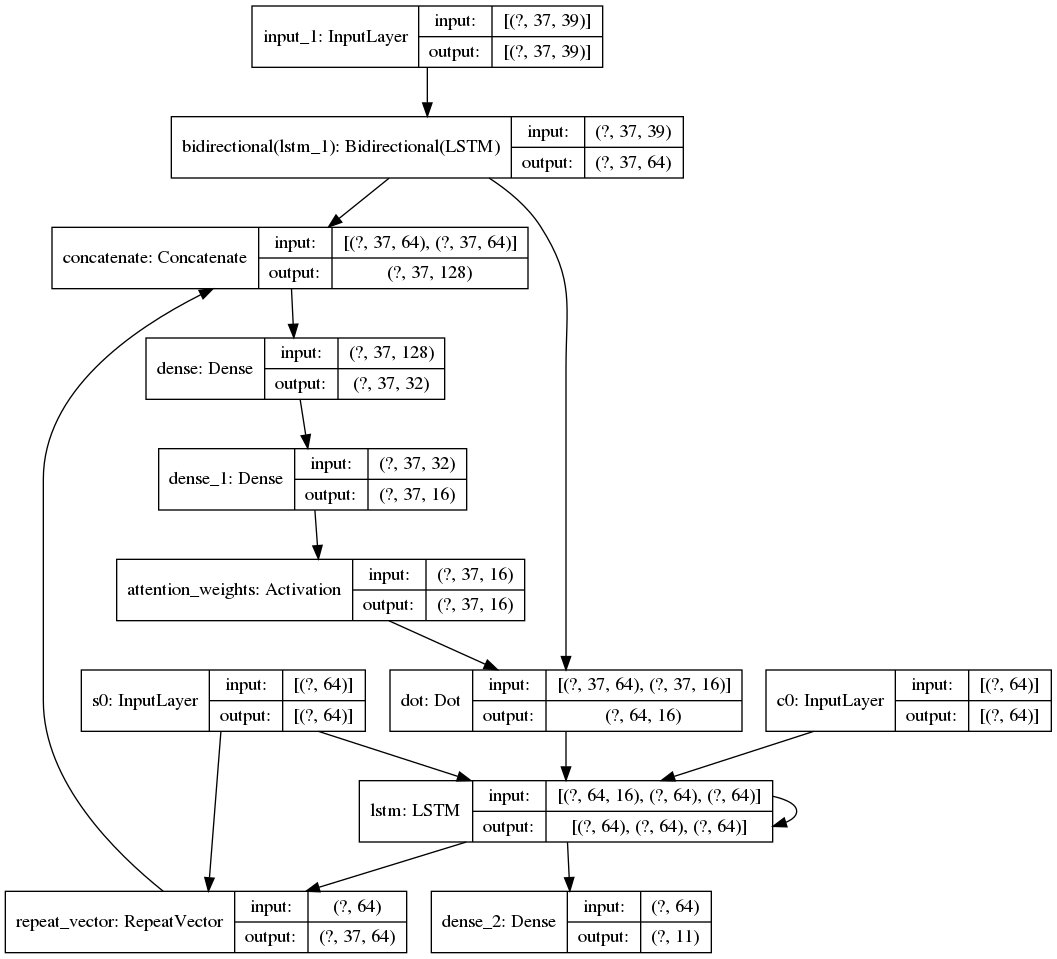

In [7]:
plot_model(model, show_shapes=True, show_layer_names=True)

Seu modelo deve ficar com uma arquitetura semelhante a esta:

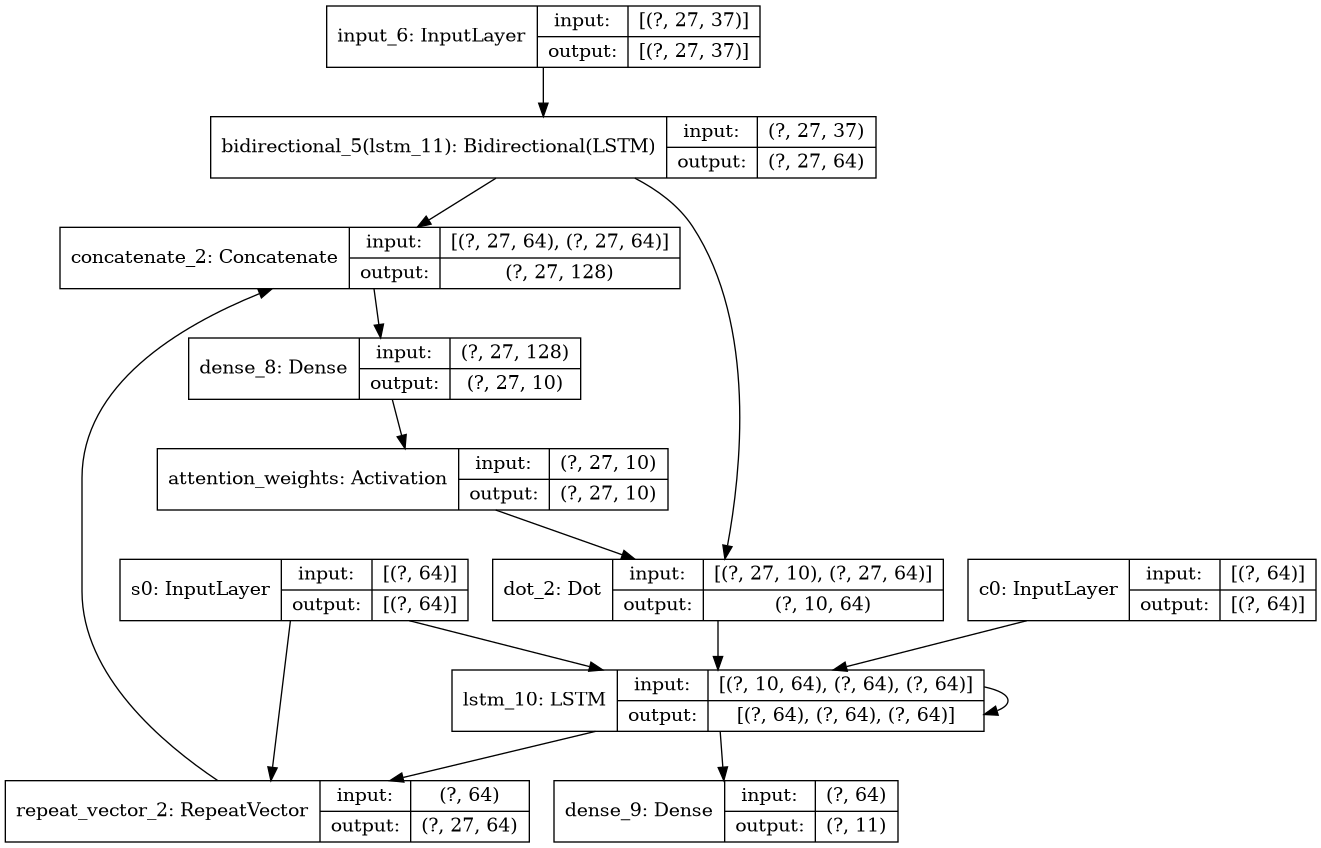

# Treinar

In [8]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

model.fit([Xoh, s0, c0], outputs, epochs=50, batch_size=100 )

Epoch 1/50
100/100 [==============================] - 53s 533ms/step - loss: 20.2638 - dense_2_loss: 1.2180 - dense_2_1_loss: 1.5564 - dense_2_2_loss: 2.3544 - dense_2_3_loss: 2.7117 - dense_2_4_loss: 1.5576 - dense_2_5_loss: 1.7903 - dense_2_6_loss: 2.6581 - dense_2_7_loss: 1.5542 - dense_2_8_loss: 2.1306 - dense_2_9_loss: 2.7324 - dense_2_accuracy: 0.4652 - dense_2_1_accuracy: 0.3539 - dense_2_2_accuracy: 0.1277 - dense_2_3_accuracy: 0.0286 - dense_2_4_accuracy: 0.7140 - dense_2_5_accuracy: 0.1802 - dense_2_6_accuracy: 0.0306 - dense_2_7_accuracy: 0.7279 - dense_2_8_accuracy: 0.0853 - dense_2_9_accuracy: 0.0307
Epoch 2/50
100/100 [==============================] - 48s 481ms/step - loss: 15.6498 - dense_2_loss: 0.6896 - dense_2_1_loss: 0.7119 - dense_2_2_loss: 1.9013 - dense_2_3_loss: 2.5389 - dense_2_4_loss: 0.6688 - dense_2_5_loss: 1.3719 - dense_2_6_loss: 2.5396 - dense_2_7_loss: 0.7309 - dense_2_8_loss: 1.8986 - dense_2_9_loss: 2.5982 - dense_2_accuracy: 0.5959 - dense_2_1_accurac

100/100 [==============================] - 53s 531ms/step - loss: 7.7864 - dense_2_loss: 0.0295 - dense_2_1_loss: 0.0322 - dense_2_2_loss: 0.8865 - dense_2_3_loss: 2.2786 - dense_2_4_loss: 0.0011 - dense_2_5_loss: 0.0922 - dense_2_6_loss: 1.8425 - dense_2_7_loss: 0.0015 - dense_2_8_loss: 0.6177 - dense_2_9_loss: 2.0047 - dense_2_accuracy: 0.9896 - dense_2_1_accuracy: 0.9891 - dense_2_2_accuracy: 0.5365 - dense_2_3_accuracy: 0.1374 - dense_2_4_accuracy: 1.0000 - dense_2_5_accuracy: 0.9758 - dense_2_6_accuracy: 0.2849 - dense_2_7_accuracy: 0.9999 - dense_2_8_accuracy: 0.7756 - dense_2_9_accuracy: 0.2347
Epoch 28/50
100/100 [==============================] - 53s 534ms/step - loss: 7.7330 - dense_2_loss: 0.0272 - dense_2_1_loss: 0.0294 - dense_2_2_loss: 0.8757 - dense_2_3_loss: 2.2816 - dense_2_4_loss: 0.0010 - dense_2_5_loss: 0.0963 - dense_2_6_loss: 1.8320 - dense_2_7_loss: 0.0011 - dense_2_8_loss: 0.6033 - dense_2_9_loss: 1.9855 - dense_2_accuracy: 0.9906 - dense_2_1_accuracy: 0.9898 - 

# Validar

In [9]:
teste,_ ,_,_  = load_dataset(30)
teste = [teste[i][0] for i in range(len(teste))]

for example in teste:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(
        list(
            map(lambda x: to_categorical(x, num_classes=len(human_vocab)),
                source)))

    source = source.reshape((1, Tx, len(human_vocab)))
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))

    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(i)] for i in prediction]

    print("input:", example)
    print("output:", ''.join(output), "\n")

100%|██████████| 30/30 [00:00<00:00, 10905.63it/s]


input: 6 dezembro 2015
output: 2015-12-06 

input: terça-feira 9 de agosto de 1983
output: 1980-08-09 

input: quinta-feira 10 de agosto de 1978
output: 1988-04-10 

input: 23/07/15
output: 2019-05-25 

input: sexta-feira 7 de fevereiro de 1997
output: 1989-01-08 

input: quarta-feira 28 de novembro de 2001
output: 2000-11-29 

input: 06 nov. 1989
output: 1989-11-01 

input: 14 01 04
output: 2008-05-14 

input: sexta-feira 1 de janeiro de 1982
output: 1980-01-01 

input: terça-feira 29 de abril de 1975
output: 1983-07-29 

input: 30 abril 1973
output: 1982-07-30 

input: terça-feira 25 de maio de 1982
output: 1980-03-25 

input: sexta-feira 13 de novembro de 1992
output: 1991-11-13 

input: 13 mar. 2004
output: 2008-05-12 

input: quinta-feira 5 de dezembro de 2019
output: 2016-12-03 

input: segunda-feira 21 de junho de 1971
output: 1991-06-21 

input: março 31 1971
output: 1971-01-21 

input: 4 de agosto de 2011
output: 2011-09-09 

input: 31 de março de 1990
output: 1990-03-31 

inp